In [1]:
!pip install pymysql

     |████████████████████████████████| 51kB 2.7MB/s 


In [2]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from keras.utils import *

In [3]:
# MySQL Connection 연결
def player_name_call():
    conn = pymysql.connect(host='49.247.132.235', user='kbo_db', password='1234', db='kbo_data_db', charset='utf8')
    # Connection 으로부터 Cursor 생성
    curs = conn.cursor()
    sql = '''select * from kbo_pitcher_player 
            union
            select * from kbo_hitter_player;'''   
    curs.execute(sql)
    rows = curs.fetchall()
    df_player_name = pd.DataFrame(rows)
    conn.close()
    df_player_name.columns = ['player_id', 'player_name']
    return df_player_name

In [4]:
def MinMax_Scaler(df_scaler):
    scaler = MinMaxScaler()
    list_scaler_name = df_scaler['player_name'].values
    
    if 'mvp' in df_scaler.columns:
        list_scaler_mvp = df_scaler['mvp'].values
        df_scaler = df_scaler.drop(['player_name', 'mvp'], axis=1)
        df_scaler[df_scaler.columns] = scaler.fit_transform(df_scaler[df_scaler.columns])
        df_scaler['mvp'] = list_scaler_mvp
    else:       
        df_scaler = df_scaler.drop('player_name', axis=1)        
        df_scaler[df_scaler.columns] = scaler.fit_transform(df_scaler[df_scaler.columns])
        
    df_scaler['player_name'] = list_scaler_name
    
    return df_scaler

In [5]:
def hit_pit_sum (df_total_hit_m, df_total_pit_m):
    conn = pymysql.connect(host='49.247.132.235', user='kbo_db', password='1234', db='kbo_data_db', \
                           charset='utf8', autocommit=True, cursorclass=pymysql.cursors.DictCursor)
    curs = conn.cursor()
    sql = '''SELECT team_year, team_rank, team_name FROM kbo_team_rank where team_year = {};'''.format(int(df_total_hit_m.player_year[0]))
    curs.execute(sql)
    rows = curs.fetchall()
    team_year_rank = pd.DataFrame(rows)
    
    curs = conn.cursor()
    sql = '''SELECT player_year, player_name FROM kbo_mvp_player where player_year = {};'''.format(int(df_total_hit_m.player_year[0]))
    curs.execute(sql)
    rows = curs.fetchall()
    df_mvp_list = pd.DataFrame(rows)
    conn.close()    
    
    df_total_hit_m.columns = ['player_id', 'player_year', 'player_team', 'player_AVG', 'player_G', 'player_PA', 'player_AB', 'player_RH', 'player_HH',
       'player_2B', 'player_3B', 'player_HRH', 'player_TB', 'player_RBI', 'player_SB', 'player_CS', 'player_BBH', 
       'player_HBPH', 'player_SOH', 'player_GDP', 'player_SLG', 'player_OBP', 'player_E']
    df_total_pit_m.columns = ['player_id', 'player_year', 'player_team', 'player_ERA', 'player_GP', 'player_CG', 'player_SHO', 'player_W', 'player_L', 
       'player_SV', 'player_HLD', 'player_WPCT', 'player_TBF', 'player_IP', 'player_HP', 'player_HRP', 'player_BBP',
       'player_HBPP', 'player_SOP', 'player_RP', 'player_ER']
    df_sum_player = pd.merge(df_total_hit_m, df_total_pit_m, how='outer')
    
    df_player_name = player_name_call()
    df_sum_player = pd.merge(df_sum_player, df_player_name, on = 'player_id', how = 'left')
    df_sum_player = df_sum_player.fillna('0')
    
    df_sum_player['player_team'] = df_sum_player['player_team'].apply(lambda x: team_year_rank['team_rank'][x == team_year_rank['team_name']].values[0])
    df_sum_player = df_sum_player.drop(['player_id', 'player_year'], axis=1)
    df_sum_player = df_sum_player.apply(lambda x: x.replace('-','0'))
    df_sum_player['player_IP'] = df_sum_player['player_IP'].apply(lambda x: x.replace(' 1/3', '.3') if(' 1/3' in x) else (x.replace(' 2/3', '.6') if(' 2/3' in x) else x))
    df_sum_player['player_IP'] = df_sum_player['player_IP'].apply(lambda x: x.replace('1/3', '0.3') if('1/3' in x) else (x.replace('2/3', '0.6') if('2/3' in x) else x))

    for i in df_sum_player.columns:
        if not i in ['player_name']:
            df_sum_player[i] = df_sum_player[i].apply(lambda x: float(x))
            
    df_hit_m = df_sum_player.drop(list(df_sum_player[(df_sum_player.player_AVG == 0) & (df_sum_player.player_G == 0)].index))
    df_pit_m = df_sum_player[df_sum_player.player_AVG == 0]
            
    df_hit_m = MinMax_Scaler(df_hit_m)
    df_pit_m = MinMax_Scaler(df_pit_m)
    df_sum_player = pd.merge(df_hit_m, df_pit_m, how='outer')
    
    if df_total_hit_m.player_year[0] != '2020':
        print(df_total_hit_m.player_year[0], end='/')
        df_sum_player['mvp'] = df_sum_player['player_name'].apply(lambda x: 1 if (df_mvp_list.player_name[0] == x) else 0)
    return df_sum_player

In [6]:
def make_team_df(data_year):
    conn = pymysql.connect(host='49.247.132.235', user='kbo_db', password='1234', db='kbo_data_db', \
                           charset='utf8', autocommit=True, cursorclass=pymysql.cursors.DictCursor)
    curs = conn.cursor()
    sql = '''select x.* from (SELECT * from kbo_hitter_total_status where player_year = {}
        and player_PA > 100 
        order by player_PA desc) x
        limit 45;'''.format(data_year)
    curs.execute(sql)
    rows = curs.fetchall()
    df_year_hit = pd.DataFrame(rows)

    curs = conn.cursor()
    sql = '''select x.* from (SELECT * from kbo_pitcher_total_status where player_year = {}
        and player_IP > 100 
        order by player_IP desc) x
        limit 15;'''.format(data_year)
    curs.execute(sql)
    rows = curs.fetchall()
    df_year_pit = pd.DataFrame(rows)
    conn.close()
    df_year_player = hit_pit_sum(df_year_hit, df_year_pit)
    return df_year_player

In [7]:
def df_train_data (data_year):
    df_train_player = pd.DataFrame()
    for i in range(2001, 2020):
        if i != data_year:
            df_year_player = make_team_df(i)
            df_train_player = pd.concat([df_train_player, df_year_player])
    df_test_player = make_team_df(data_year)
    return df_train_player, df_test_player

In [8]:
df_trian_2019, df_test_2019 = df_train_data(2019)

2001/2002/2003/2004/2005/2006/2007/2008/2009/2010/2011/2012/2013/2014/2015/2016/2017/2018/2019/

In [9]:
y = df_trian_2019['mvp']
x = df_trian_2019.drop(['player_name', 'mvp'], axis=1)
x_test = df_test_2019.drop(['player_name', 'mvp'], axis=1)

# DNN

In [10]:
model_1 = Sequential()

model_1.add(Dense(512, activation='relu', input_shape=(39,)))  # input layer 생성
model_1.add(Dense(256, activation='relu'))                    # hidden layer 생성
model_1.add(Dense(128, activation='relu'))                    # hidden layer 생성
model_1.add(Dense(2, activation='softmax'))                  # output layer 생성

In [11]:
model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')

In [12]:
y2 = to_categorical(y)

In [ ]:
hist = model_1.fit(x, y2, epochs=200, validation_split=0.1)

In [14]:
preds = model_1.predict(x_test)

In [15]:
df_temp_1 = pd.DataFrame()
df_temp_1['pred'] = preds[:,1]
df_temp_1['pred0'] = preds[:,0]

In [20]:
df_temp_1['name'] = df_test_2019['player_name'].values

In [17]:
df_temp_1.sort_values('pred', ascending=False)[:10]

,pred,pred0,name
2,0.350342,0.649658,김하성
49,0.328256,0.671744,양현종
45,0.304374,0.695626,린드블럼
6,0.299228,0.700772,최정
24,0.224150,0.775850,박병호
5,0.118126,0.881874,샌즈
25,0.083088,0.916912,오재일
9,0.077259,0.922741,로맥
11,0.035168,0.964832,로하스
47,0.019515,0.980485,김광현


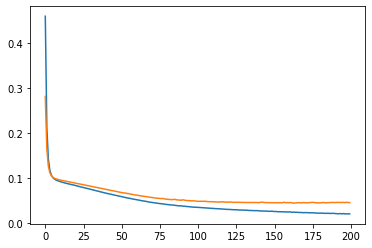

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

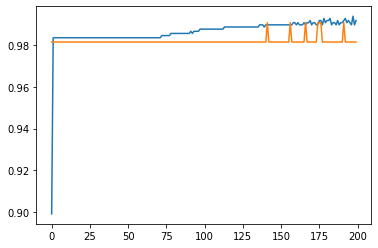

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])